In [70]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from mycolorpy import colorlist as mcp

from z_base import Mols,T_ZERO

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=15)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams['figure.subplot.left'] = 0.08
plt.rcParams['figure.subplot.right'] = 0.99
plt.rcParams['figure.subplot.top'] = 0.99
plt.rcParams['figure.subplot.bottom'] = 0.09

In [87]:
D = pd.read_csv(r'Datas\MD.csv', index_col=0)
V = pd.read_csv(r'Datas\All_viscosity.csv', index_col=0)
D['D']*=1e-4

In [90]:
D

,compound,x,Temperature,D
0,butanol,100,25,2.341000e-10
2,dmag,0,25,9.000000e-12
3,ocm,0,25,1.600000e-12
4,peta,0,25,1.500000e-12


In [91]:
Ds = {
    Mols.butanol: 2.6000e-10,
    Mols.dmeg: 9.00000e-12,
    Mols.peta: 1.500000e-12,
    Mols.ocm: 1.600000e-12,
}
Hs = {}

In [92]:
fil = ((V['w'] == 0) | (V['w'] == 100)) & ((T_ZERO + 24 <= V['T']) & (V['T'] <= T_ZERO + 26))

for comp, group in V[fil].groupby(by='compound'):
    Nu = group['Nu'].mean()
    D_val = Ds[Mols[comp]]
    Hs[Mols[comp]] = Nu * D_val / (T_ZERO + 25)
Hs

{<Mols.butanol: 'BUT'>: 2.460682622201992e-12,
 <Mols.dmeg: 'DME'>: 1.2411228911621668e-13,
 <Mols.ocm: 'OCM'>: 6.874957159148081e-13,
 <Mols.peta: 'PET'>: 4.324945639443233e-12}

In [93]:
V['D_comp'] = V.apply(lambda v: Hs[Mols[v['compound']]] * v['T'] / v['Nu'], axis=1)
V['ln_D_comp'] = np.log10(V['D_comp'])
V['D_but'] = V.apply(lambda v: Hs[Mols.butanol] * v['T'] / v['Nu'], axis=1)
V['ln_D_but']= np.log10(V['D_but'])
# V.to_csv(r'Datas\MD_results.csv')

In [94]:
V['D_but']=V.apply(lambda v: np.nan if v['w']==0 else v['D_but'] , axis=1)
V['ln_D_but']=V.apply(lambda v: np.nan if v['w']==0 else v['ln_D_but'] , axis=1)

In [95]:
V.to_csv(r'Datas\MD_viscosity.csv')

# old

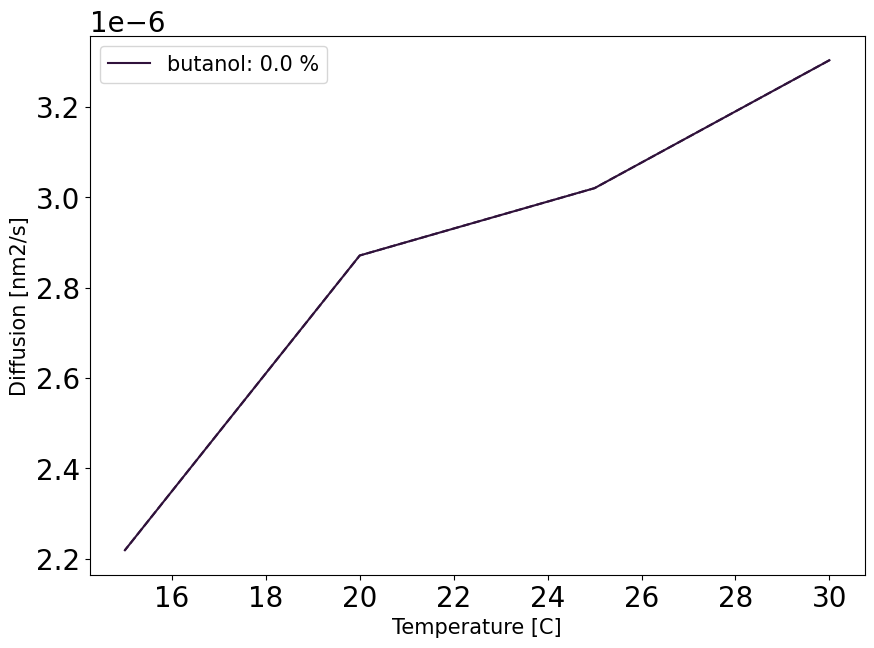

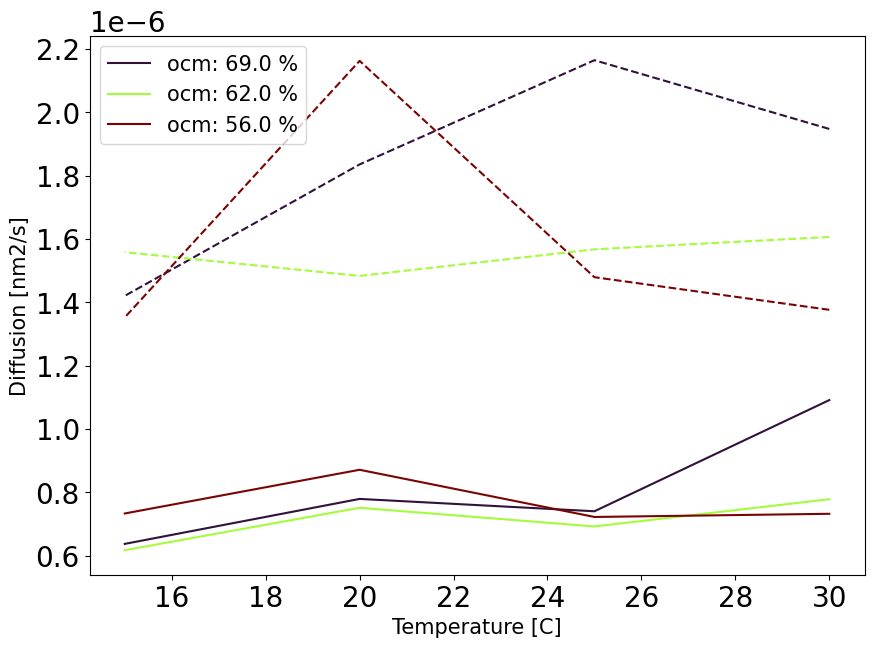

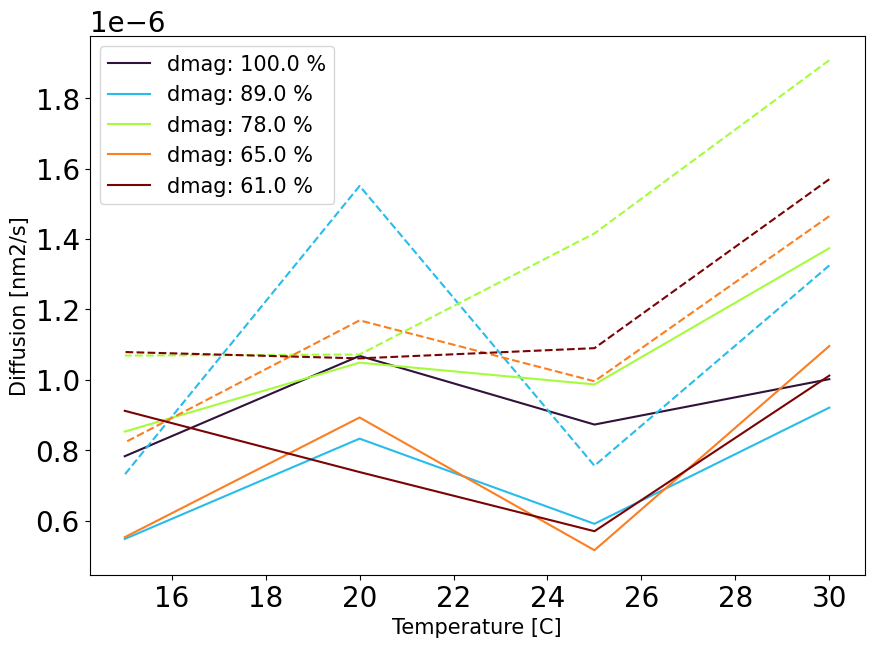

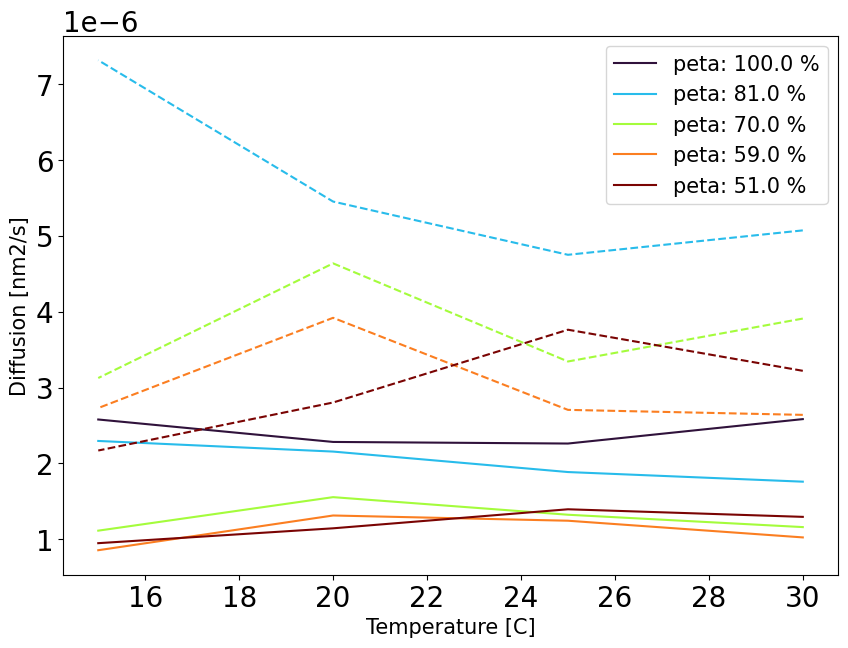

In [ ]:
# D
colors_list = mcp.gen_color(
    cmap="turbo",
    n=len(D['compound'].unique()),
)
for  compound in Mols:
    df_sub = D[D['compound'] == compound.name]
    if len(df_sub) == 0:
        continue
    colors_list = mcp.gen_color(
        cmap="turbo",
        n=len(df_sub['x'].unique()),
    )
    i=-1
    fig, ax = plt.subplots(num="DT")
    for [x], df in df_sub.groupby(by=['x']):
        i+=1
        data_x = df.sort_values(by=['T'], ascending=False)
        ax.plot(
            data_x['T']-T_ZERO,
            data_x['D_comp'],
            label=f"{compound.name}: {100-x} %",
            c=colors_list[i],
        )
        ax.plot(
            data_x['T']-T_ZERO,
            data_x['D_but'],
            linestyle='dashed',
            # label=f"Butanol: {x} %",
            c=colors_list[i],
        )

    ax.set_xlabel('Temperature [C]')
    ax.set_ylabel('Diffusion [nm2/s]')
    ax.legend()
    plt.show()

In [87]:
# Mean H from D
def calculate_h_comp(r: pd.Series):
    T = r['T']
    v = r['Nu']
    D_comp = r['D_comp']
    return T / (v * D_comp)


def calculate_h_but(r: pd.Series):
    T = r['T']
    v = r['Nu']
    D_but = r['D_but']
    return T / (v * D_but)


V['x'] = V['x'].astype(int)
M = pd.merge(D, V, on=['x', 'T', 'compound'], how='inner')

d_dict = {}
for name, group in M.groupby(by='compound'):
    H_comp = np.array(group.apply(calculate_h_comp, axis=1))
    if name == 'butanol':
        H_but = np.array(M.apply(calculate_h_but, axis=1).dropna())
        H_comp = np.array([*H_comp, *H_but])
    d_dict[name] = np.median(H_comp)

def calculate_D(r):
    v = r['Nu']
    T = r['T']
    comp = r['compound']
    h = d_dict[comp]
    return T / v / h


def calculate_D_but(r):
    v = r['Nu']
    T = r['T']
    h = d_dict['butanol']
    return T / v / h


M['D_comp1'] = M.apply(calculate_D, axis=1)
M['D_but1'] = M.apply(calculate_D_but, axis=1)

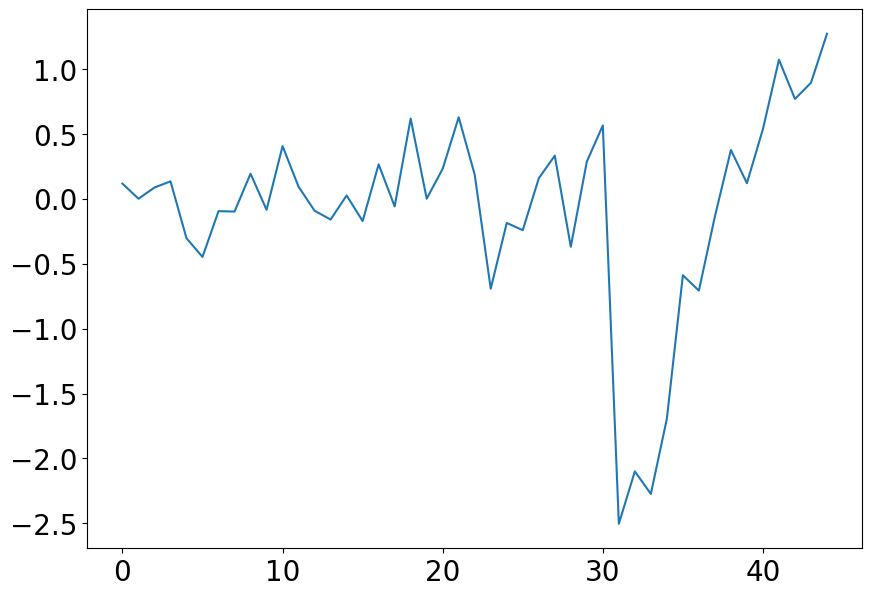

In [88]:
plt.plot(
    np.log(M['D_comp1']/M['D_comp'])
)